In [1]:
# Completely clean up and reinstall compatible NumPy
!pip uninstall -y numpy
!pip install numpy==1.23.5  # Stable with PyTorch and torchvision in Colab

Found existing installation: numpy 2.3.1
Uninstalling numpy-2.3.1:
  Successfully uninstalled numpy-2.3.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 106.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
facenet-pytorch 2.6.0 requires numpy<2.0.0,>=1.24.0, but you have numpy 1.23.5 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
albumentations 2.0.8 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
xarray 2025.3.1 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
chex 0.1.89 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
blosc2 3.5.0 requires numpy>=1.26, but you have numpy 1.23.5 which is incompatible.
bigframes 2.8.0 requir

In [ ]:
!pip uninstall -y pillow
!pip install pillow==10.2.0

In [1]:
!pip install -q kaggle
!pip install -q torch torchvision scikit-learn
!pip install -q facenet-pytorch

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [2]:
from google.colab import files
files.upload()  # Choose kaggle.json from your computer

Saving kaggle.json to kaggle (2).json


{'kaggle (2).json': b'{"username":"aashikagupta1","key":"713646162a9cd12306b88ee84be39387"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d shuvoalok/ck-dataset
!unzip -q ck-dataset.zip -d ck_dataset

Dataset URL: https://www.kaggle.com/datasets/shuvoalok/ck-dataset
License(s): other
ck-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
replace ck_dataset/anger/S010_004_00000017.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [53]:
import os
import random
from PIL import Image
from torch.utils.data import Dataset

class CKPlusPairsDataset(Dataset):
    def __init__(self, root, transform=None, max_pairs_per_class=1000):
        self.transform = transform
        self.data = []

        expression_dirs = sorted(os.listdir(root))  # Each folder is an expression class
        for expression in expression_dirs:
            class_path = os.path.join(root, expression)
            image_files = sorted(os.listdir(class_path))

            if len(image_files) < 2:
                continue

            # Randomly sample pairs from this expression class
            sampled_pairs = 0
            while sampled_pairs < max_pairs_per_class:
                img1, img2 = random.sample(image_files, 2)
                if img1 != img2:
                    img_path1 = os.path.join(class_path, img1)
                    img_path2 = os.path.join(class_path, img2)
                    self.data.append((img_path1, img_path2))
                    sampled_pairs += 1

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path1, img_path2 = self.data[idx]
        img1 = Image.open(img_path1).convert("L")
        img2 = Image.open(img_path2).convert("L")

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2

In [54]:
import os

# List folder contents
os.listdir("ck_dataset")

['happy', 'disgust', 'fear', 'anger', 'surprise', 'contempt', 'sadness']

Total pairs: 7000
Image shape: torch.Size([1, 112, 112])


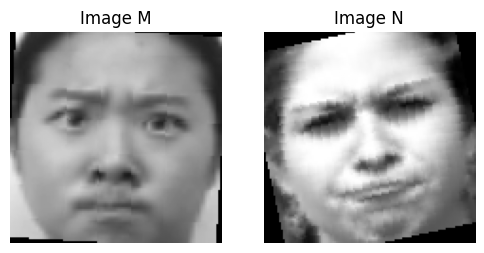

In [55]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define basic image transform
transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor()
])


# ✅ Corrected dataset path
dataset_path = "ck_dataset"
dataset = CKPlusPairsDataset(root=dataset_path, transform=transform)
# Create the DataLoader
loader = DataLoader(dataset, batch_size=32, shuffle=True)


# Preview size and shape
print("Total pairs:", len(dataset))
img1, img2 = dataset[0]
print("Image shape:", img1.shape)

# Plot the pair
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.imshow(img1.squeeze(), cmap="gray")
plt.title("Image M")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(img2.squeeze(), cmap="gray")
plt.title("Image N")
plt.axis("off")

plt.show()

In [56]:
img_path1, img_path2 = dataset.data[0]
print("File 1:", img_path1)
print("File 2:", img_path2)

File 1: ck_dataset/anger/S502_001_00000015.png
File 2: ck_dataset/anger/S109_003_00000017.png


In [57]:
from torchvision.models import resnet18, ResNet18_Weights

In [58]:
import torch.nn as nn
import torch.nn.functional as F

In [65]:
class ExpressionEncoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        base = resnet18(weights=ResNet18_Weights.DEFAULT)
        base.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.features = nn.Sequential(*list(base.children())[:-2])
        self.fc = nn.Linear(512 * 7 * 7, latent_dim)
        # Dummy forward pass to get feature size
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, 112, 112)
            dummy_output = self.features(dummy_input)
            self.feature_dim = dummy_output.view(1, -1).shape[1]
            self.fc = nn.Linear(self.feature_dim, latent_dim)  # Will now be Linear(8192, 128)


    def forward(self, x):
        x = self.features(x)
        flat = x.view(x.size(0), -1)
        emb = self.fc(flat)
        emb = F.normalize(emb, dim=1)
        return emb, x

In [66]:
print(f_m.shape)

torch.Size([32, 512, 4, 4])


In [67]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [68]:
class GlobalStatisticsNetwork(nn.Module):
    def __init__(self, latent_dim=128, hidden_dim=256):
        super(GlobalStatisticsNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim * 2, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, e1, e2):
        # Concatenate expression embeddings
        h = torch.cat([e1, e2], dim=1)
        return self.net(h)

class LocalStatisticsNetwork(nn.Module):
    def __init__(self, in_channels=512, hidden_channels=512):
        super(LocalStatisticsNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels * 2, hidden_channels, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_channels, 1, kernel_size=1)
        )

    def forward(self, feat1, feat2):
        """
        Takes two feature maps of shape [B, C, H, W] and estimates MI at each location.
        Returns: [B, 1, H, W]
        """
        x = torch.cat([feat1, feat2], dim=1)  # Concatenate along channel dimension
        return self.net(x)


In [74]:
def mi_dv_loss(U, e_m, e_n):
    """
    DV Mutual Information loss with stabilization
    """
    # In mi_dv_loss
    e_n_shuffled = e_n[torch.randperm(e_n.size(0))]
    pos = torch.clamp(U(e_m, e_n), min=-5, max=5)
    neg = torch.clamp(U(e_m, e_n_shuffled), min=-5, max=5)




    # Log-sum-exp trick for stability
    logsumexp = torch.logsumexp(neg, dim=0) - torch.log(torch.tensor(neg.size(0), device=neg.device, dtype=torch.float))

    # Mutual Information estimate
    mi = torch.mean(pos) - logsumexp
    return -mi

def mi_local_loss(U_local, f_m, f_n):
    """
    Computes local mutual information loss between feature maps f_m and f_n using U_local.

    f_m, f_n: Feature maps from expression encoder (shape: [B, C, H, W])
    """
    # Positive: (f_m, f_n)
    idx = torch.randperm(f_n.size(0))
    f_n_shuffled = f_n[idx]
    pos = torch.clamp(U_local(f_m, f_n), min=-5, max=5)
    neg = torch.clamp(U_local(f_m, f_n_shuffled), min=-5, max=5)


    # Negative: (f_m, shuffled f_n)


    # Mean over spatial locations and batch
    pos_mean = torch.mean(pos)
    neg_logsumexp = torch.logsumexp(neg.view(neg.size(0), -1), dim=1).mean()
    return -(pos_mean - neg_logsumexp)


In [75]:
import torch.optim as optim
from torch.utils.data import DataLoader

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model init
encoder_exp = ExpressionEncoder(latent_dim=128).to(device)
stats_net_global = GlobalStatisticsNetwork(latent_dim=128).to(device)
stats_net_local = LocalStatisticsNetwork(in_channels=512).to(device)

optimizer = optim.Adam(
    list(encoder_exp.parameters()) +
    list(stats_net_global.parameters()) +
    list(stats_net_local.parameters()), lr=1e-3
)

# Loss weights
λ_local = 0.001
δ = 0.1  # L1 weight

for epoch in range(15):
    total_loss = 0.0
    for img_m, img_n in loader:
        img_m, img_n = img_m.to(device), img_n.to(device)

        # Embeddings and feature maps
        e_m, f_m = encoder_exp(img_m)
        e_n, f_n = encoder_exp(img_n)

        # Cross-referenced MI
        loss_global = mi_dv_loss(stats_net_global, e_m, e_n) + mi_dv_loss(stats_net_global, e_n, e_m)
        loss_local = mi_local_loss(stats_net_local, f_m, f_n) + mi_local_loss(stats_net_local, f_n, f_m)

        # L1 similarity loss
        l1_distance = F.l1_loss(e_m, e_n)

        # Combined loss
        loss = loss_global + λ_local * loss_local - δ * l1_distance

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}: Total Loss = {total_loss / len(loader):.4f}")


Epoch 1: Total Loss = -0.0003
Epoch 2: Total Loss = -0.0002
Epoch 3: Total Loss = 0.0016
Epoch 4: Total Loss = -0.0018
Epoch 5: Total Loss = -0.0027
Epoch 6: Total Loss = -0.0099
Epoch 7: Total Loss = -0.0259
Epoch 8: Total Loss = -0.1192
Epoch 9: Total Loss = -0.2274
Epoch 10: Total Loss = -0.3472
Epoch 11: Total Loss = -0.8224
Epoch 12: Total Loss = -1.1727
Epoch 13: Total Loss = -1.7561
Epoch 14: Total Loss = -2.2418
Epoch 15: Total Loss = -2.6637


In [83]:
import torch.nn as nn

class IdentityEncoder(nn.Module):
    def __init__(self, latent_dim=128):
        super(IdentityEncoder, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, 4, stride=2, padding=1),  # 48x48 -> 24x24
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),  # 24x24 -> 12x12
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),  # 12x12 -> 6x6
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)  # Output: [B, 128, 1, 1]
        )
        self.fc = nn.Linear(128, latent_dim)
        self.bn = nn.BatchNorm1d(latent_dim)  # Optional for stability

    def forward(self, x):
        x = self.cnn(x)  # [B, 128, 1, 1]
        x = x.view(x.size(0), -1)  # [B, 128]
        x = self.fc(x)             # [B, latent_dim]
        x = self.bn(x)             # [B, latent_dim]
        return x


# Separate statistics network for identity-expression MI
class AdversarialStatisticsNetwork(nn.Module):
    def __init__(self, latent_dim=128, hidden_dim=256):
        super(AdversarialStatisticsNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, id_feat, exp_feat):
        h = torch.cat([id_feat, exp_feat], dim=1)
        return self.net(h)

In [84]:
def adversarial_mi_loss(U_adv, id_feat, exp_feat):
    """
    U_adv: statistics network trying to detect MI between identity & expression
    id_feat: identity representation
    exp_feat: expression representation (frozen)
    """
    # Positive pair (id, exp)
    pos = U_adv(id_feat, exp_feat)

    # Negative pair (id, shuffled exp)
    exp_shuffled = exp_feat[torch.randperm(exp_feat.size(0))]
    neg = U_adv(id_feat, exp_shuffled)

    # Log-sum-exp trick for stability
    logsumexp = torch.logsumexp(neg, dim=0) - torch.log(torch.tensor(neg.size(0), dtype=torch.float, device=neg.device))

    mi = torch.mean(pos) - logsumexp
    return mi  # No negative sign — because we alternate maximization & minimization

In [85]:
import torch.nn.functional as F

def orthogonality_loss(expr_feat, id_feat):
    """
    Encourages orthogonality between expression and identity embeddings.
    Assumes input features are already normalized.
    Loss = mean squared cosine similarity.
    """
    # Normalize embeddings
    expr_feat = F.normalize(expr_feat, dim=1)
    id_feat = F.normalize(id_feat, dim=1)

    # Compute dot product (cosine similarity) between each pair
    cosine_sim = torch.sum(expr_feat * id_feat, dim=1)

    # We want this similarity to be close to 0 => square it
    loss = torch.mean(cosine_sim ** 2)
    return loss


In [88]:
# Stage 2: Identity Encoder Adversarial Training
encoder_id = IdentityEncoder(latent_dim=128).to(device)
adv_stats_net = AdversarialStatisticsNetwork(latent_dim=128).to(device)

optimizer_id = optim.Adam(encoder_id.parameters(), lr=1e-3)
optimizer_adv = optim.Adam(adv_stats_net.parameters(), lr=1e-3)

encoder_exp.eval()  # Freeze expression encoder

ζadv = 0.025  # Orthogonality coefficient

for epoch in range(30):
    total_adv_loss = 0.0
    total_id_loss = 0.0
    total_orth_loss = 0.0

    for img_m, img_n in loader:
        img_m, img_n = img_m.to(device), img_n.to(device)

        # Get frozen expression features
        with torch.no_grad():
            exp_feat, _ = encoder_exp(img_m)

        # Get identity features
        id_feat = encoder_id(img_m)

        # === Diagnostic: Norm and variance checks ===


        # === 1. Train Discriminator (maximize MI) ===
        mi = adversarial_mi_loss(adv_stats_net, id_feat.detach(), exp_feat.detach())
        loss_adv = -mi
        optimizer_adv.zero_grad()
        loss_adv.backward()
        optimizer_adv.step()

        # === 2. Train Identity Encoder (minimize MI + orthogonality) ===
        mi = adversarial_mi_loss(adv_stats_net, id_feat, exp_feat.detach())
        orth_loss = orthogonality_loss(exp_feat.detach(), id_feat)

        loss_id = mi + ζadv * orth_loss
        optimizer_id.zero_grad()
        loss_id.backward()

        # === Diagnostic: Gradient flow check ===


        optimizer_id.step()

        total_adv_loss += loss_adv.item()
        total_id_loss += mi.item()
        total_orth_loss += orth_loss.item()

    print(f"Epoch {epoch+1} | Stats Loss: {total_adv_loss / len(loader):.4f} | Identity MI Loss: {total_id_loss / len(loader):.4f} | Orth Loss: {total_orth_loss / len(loader):.4f}")


Epoch 1 | Stats Loss: 0.0110 | Identity MI Loss: -0.0074 | Orth Loss: 0.0132
Epoch 2 | Stats Loss: -0.0044 | Identity MI Loss: 0.0056 | Orth Loss: 0.0176
Epoch 3 | Stats Loss: -0.0051 | Identity MI Loss: 0.0083 | Orth Loss: 0.0096
Epoch 4 | Stats Loss: -0.0002 | Identity MI Loss: 0.0035 | Orth Loss: 0.0097
Epoch 5 | Stats Loss: 0.0024 | Identity MI Loss: 0.0022 | Orth Loss: 0.0061
Epoch 6 | Stats Loss: -0.0088 | Identity MI Loss: 0.0097 | Orth Loss: 0.0032
Epoch 7 | Stats Loss: -0.0103 | Identity MI Loss: 0.0100 | Orth Loss: 0.0051
Epoch 8 | Stats Loss: 0.0022 | Identity MI Loss: 0.0032 | Orth Loss: 0.0022
Epoch 9 | Stats Loss: -0.0053 | Identity MI Loss: 0.0084 | Orth Loss: 0.0042
Epoch 10 | Stats Loss: -0.0134 | Identity MI Loss: 0.0149 | Orth Loss: 0.0074
Epoch 11 | Stats Loss: -0.0076 | Identity MI Loss: 0.0087 | Orth Loss: 0.0080
Epoch 12 | Stats Loss: -0.0155 | Identity MI Loss: 0.0201 | Orth Loss: 0.0117
Epoch 13 | Stats Loss: -0.0075 | Identity MI Loss: 0.0111 | Orth Loss: 0.00

In [89]:
class ExpressionClassifier(nn.Module):
    def __init__(self, input_dim=128, num_classes=7):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.net(x)

In [91]:
import os
from PIL import Image
from torch.utils.data import Dataset

class CKPlusLabeledDataset(Dataset):
    def __init__(self, root, transform=None):
        self.data = []
        self.labels = []
        self.transform = transform
        self.label_map = {}  # Maps folder names to numeric labels
        current_label = 0

        for expression in sorted(os.listdir(root)):
            class_path = os.path.join(root, expression)
            if not os.path.isdir(class_path):
                continue
            if expression not in self.label_map:
                self.label_map[expression] = current_label
                current_label += 1

            for img_file in sorted(os.listdir(class_path)):
                img_path = os.path.join(class_path, img_file)
                self.data.append(img_path)
                self.labels.append(self.label_map[expression])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = Image.open(self.data[idx]).convert("L")
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

In [92]:
labeled_dataset = CKPlusLabeledDataset(root="ck_dataset", transform=transform)
labeled_loader = DataLoader(labeled_dataset, batch_size=32, shuffle=True)

In [93]:
classifier = ExpressionClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer_cls = torch.optim.Adam(classifier.parameters(), lr=1e-3)

encoder_exp.eval()  # Freeze expression encoder

for epoch in range(10):
    total_loss = 0
    correct = 0
    total = 0
    for imgs, labels in labeled_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        with torch.no_grad():
            emb, _ = encoder_exp(imgs)

        outputs = classifier(emb)
        loss = criterion(outputs, labels)

        optimizer_cls.zero_grad()
        loss.backward()
        optimizer_cls.step()

        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = 100.0 * correct / total
    print(f"Epoch {epoch+1} | Loss: {total_loss:.4f} | Accuracy: {acc:.2f}%")

Epoch 1 | Loss: 56.1207 | Accuracy: 59.63%
Epoch 2 | Loss: 42.9855 | Accuracy: 70.44%
Epoch 3 | Loss: 28.6428 | Accuracy: 71.66%
Epoch 4 | Loss: 19.9795 | Accuracy: 78.19%
Epoch 5 | Loss: 15.5482 | Accuracy: 86.75%
Epoch 6 | Loss: 13.2944 | Accuracy: 88.38%
Epoch 7 | Loss: 11.4301 | Accuracy: 90.32%
Epoch 8 | Loss: 10.5696 | Accuracy: 88.99%
Epoch 9 | Loss: 10.2350 | Accuracy: 89.70%
Epoch 10 | Loss: 9.5876 | Accuracy: 89.60%


Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7a05b57722a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: /usr/local/lib/python3.11/dist-packages/numpy.libs/libopenblas64_p-r0-742d56dc

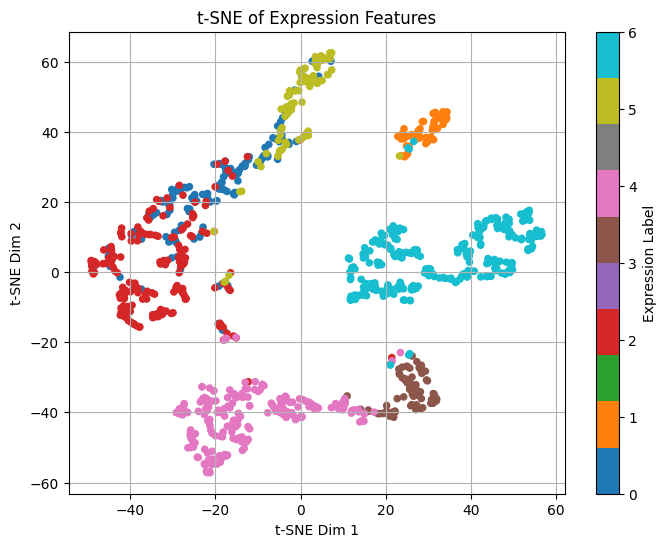

In [94]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# For this, we need a loader that includes expression labels (folder names)
class CKPlusLabeledDataset(Dataset):
    def __init__(self, root, transform=None):
        self.samples = []
        self.labels = []
        self.transform = transform
        self.label_map = {}  # map string expression to int

        expressions = sorted(os.listdir(root))
        for idx, expr in enumerate(expressions):
            self.label_map[expr] = idx
            expr_folder = os.path.join(root, expr)
            for fname in os.listdir(expr_folder):
                if fname.endswith('.png'):
                    self.samples.append(os.path.join(expr_folder, fname))
                    self.labels.append(idx)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image = Image.open(self.samples[idx]).convert("L")
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]

# Reload dataset with labels
labeled_dataset = CKPlusLabeledDataset(root="ck_dataset", transform=transform)
labeled_loader = DataLoader(labeled_dataset, batch_size=32, shuffle=False)

# Encode expression features
expression_features = []
expression_labels = []

with torch.no_grad():
    for imgs, labels in labeled_loader:
        imgs = imgs.to(device)
        feats, _ = encoder_exp(imgs)
        feats = feats.cpu().numpy()
        expression_features.append(feats)
        expression_labels.extend(labels.numpy())

expression_features = np.vstack(expression_features)

# Run t-SNE
tsne = TSNE(n_components=2, perplexity=15, random_state=0)
tsne_proj = tsne.fit_transform(expression_features)

# Plot
plt.figure(figsize=(8,6))
scatter = plt.scatter(tsne_proj[:,0], tsne_proj[:,1], c=expression_labels, cmap='tab10', s=20)
plt.title("t-SNE of Expression Features")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.colorbar(scatter, label="Expression Label")
plt.grid(True)
plt.show()

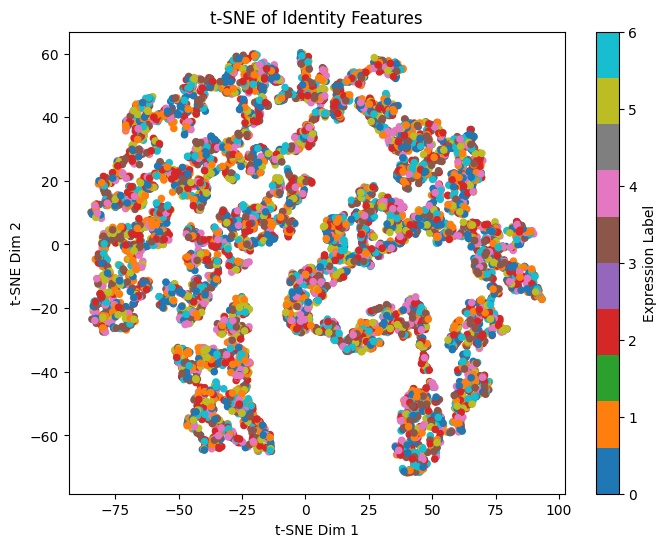

In [95]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Identity features and expression labels
identity_feats = []
expression_labels = []

for img_m, img_n in loader:
    img_m = img_m.to(device)
    with torch.no_grad():
        identity_feat = encoder_id(img_m).cpu().numpy()
    identity_feats.append(identity_feat)

    # Dummy expression label just for coloring (modify if real labels available)
    batch_size = img_m.shape[0]
    expression_labels.extend([i % 7 for i in range(batch_size)])  # simulate 7 classes

identity_feats = np.vstack(identity_feats)

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_id = tsne.fit_transform(identity_feats)

# Plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(tsne_id[:, 0], tsne_id[:, 1], c=expression_labels, cmap='tab10', s=20)
plt.title("t-SNE of Identity Features")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.colorbar(scatter, label="Expression Label")
plt.show()

In [96]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchvision.transforms.functional import to_pil_image
import random

# Sample 50 random images from labeled dataset
sample_size = 50
sample_indices = random.sample(range(len(labeled_dataset)), sample_size)

images = []
expressions = []
with torch.no_grad():
    for idx in sample_indices:
        img, label = labeled_dataset[idx]
        images.append(img)
        expressions.append(label)

images_tensor = torch.stack(images).to(device)
expression_embeddings, _ = encoder_exp(images_tensor)
expression_embeddings = expression_embeddings.cpu()

In [97]:
import torch.nn.functional as F

# Normalize embeddings for cosine similarity
normalized_embeddings = F.normalize(expression_embeddings, dim=1)

# Compute pairwise cosine similarity
cos_sim = torch.matmul(normalized_embeddings, normalized_embeddings.T)

# For distances: 1 - sim
cos_dist = 1 - cos_sim

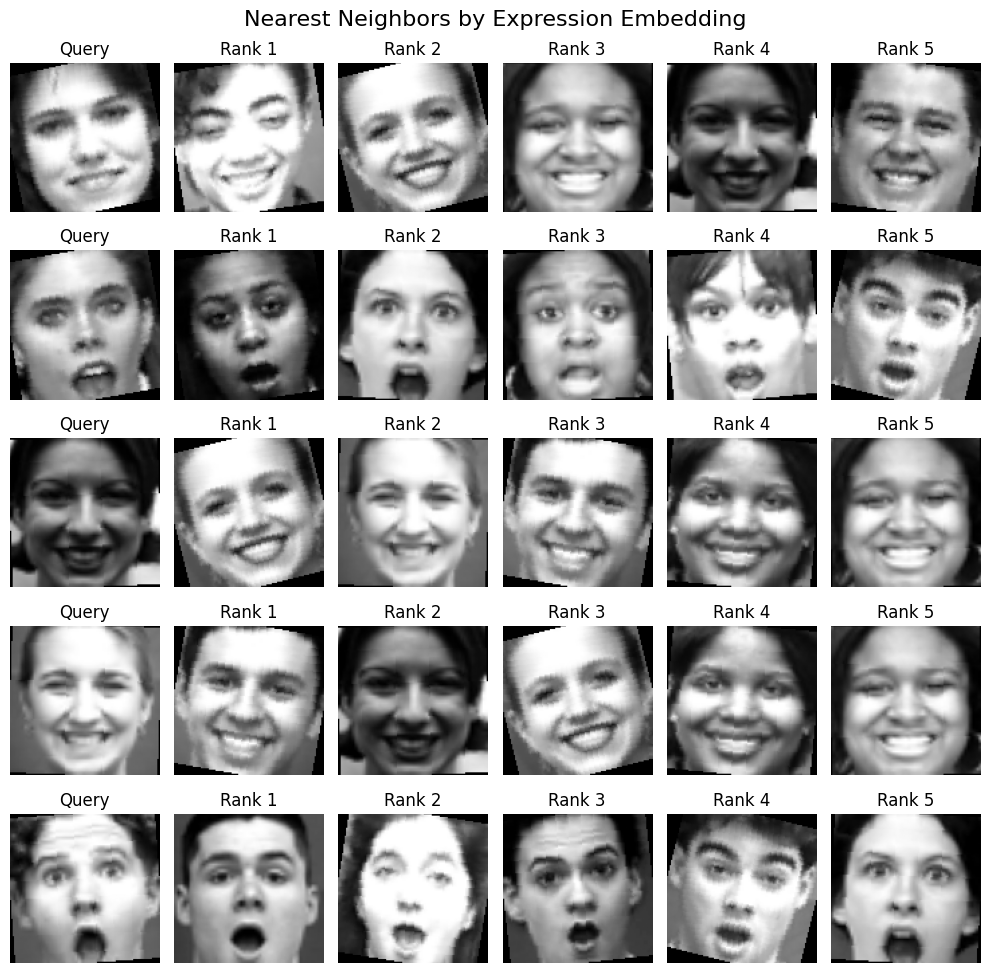

In [98]:
def plot_nearest_neighbors(images, distances, k=5):
    num_queries = 5  # Show for first 5 queries
    fig, axes = plt.subplots(num_queries, k + 1, figsize=(k * 2, num_queries * 2))
    fig.suptitle("Nearest Neighbors by Expression Embedding", fontsize=16)

    for i in range(num_queries):
        # Show query
        query_img = to_pil_image(images[i].cpu())
        axes[i][0].imshow(query_img, cmap='gray')
        axes[i][0].set_title("Query")
        axes[i][0].axis("off")

        # Get k nearest (excluding self)
        nearest_indices = distances[i].argsort()[1:k + 1]  # skip self (0th)
        for j, idx in enumerate(nearest_indices):
            neighbor_img = to_pil_image(images[idx].cpu())
            axes[i][j + 1].imshow(neighbor_img, cmap='gray')
            axes[i][j + 1].set_title(f"Rank {j+1}")
            axes[i][j + 1].axis("off")

    plt.tight_layout()
    plt.show()

# Plot
plot_nearest_neighbors(images_tensor.cpu(), cos_dist)

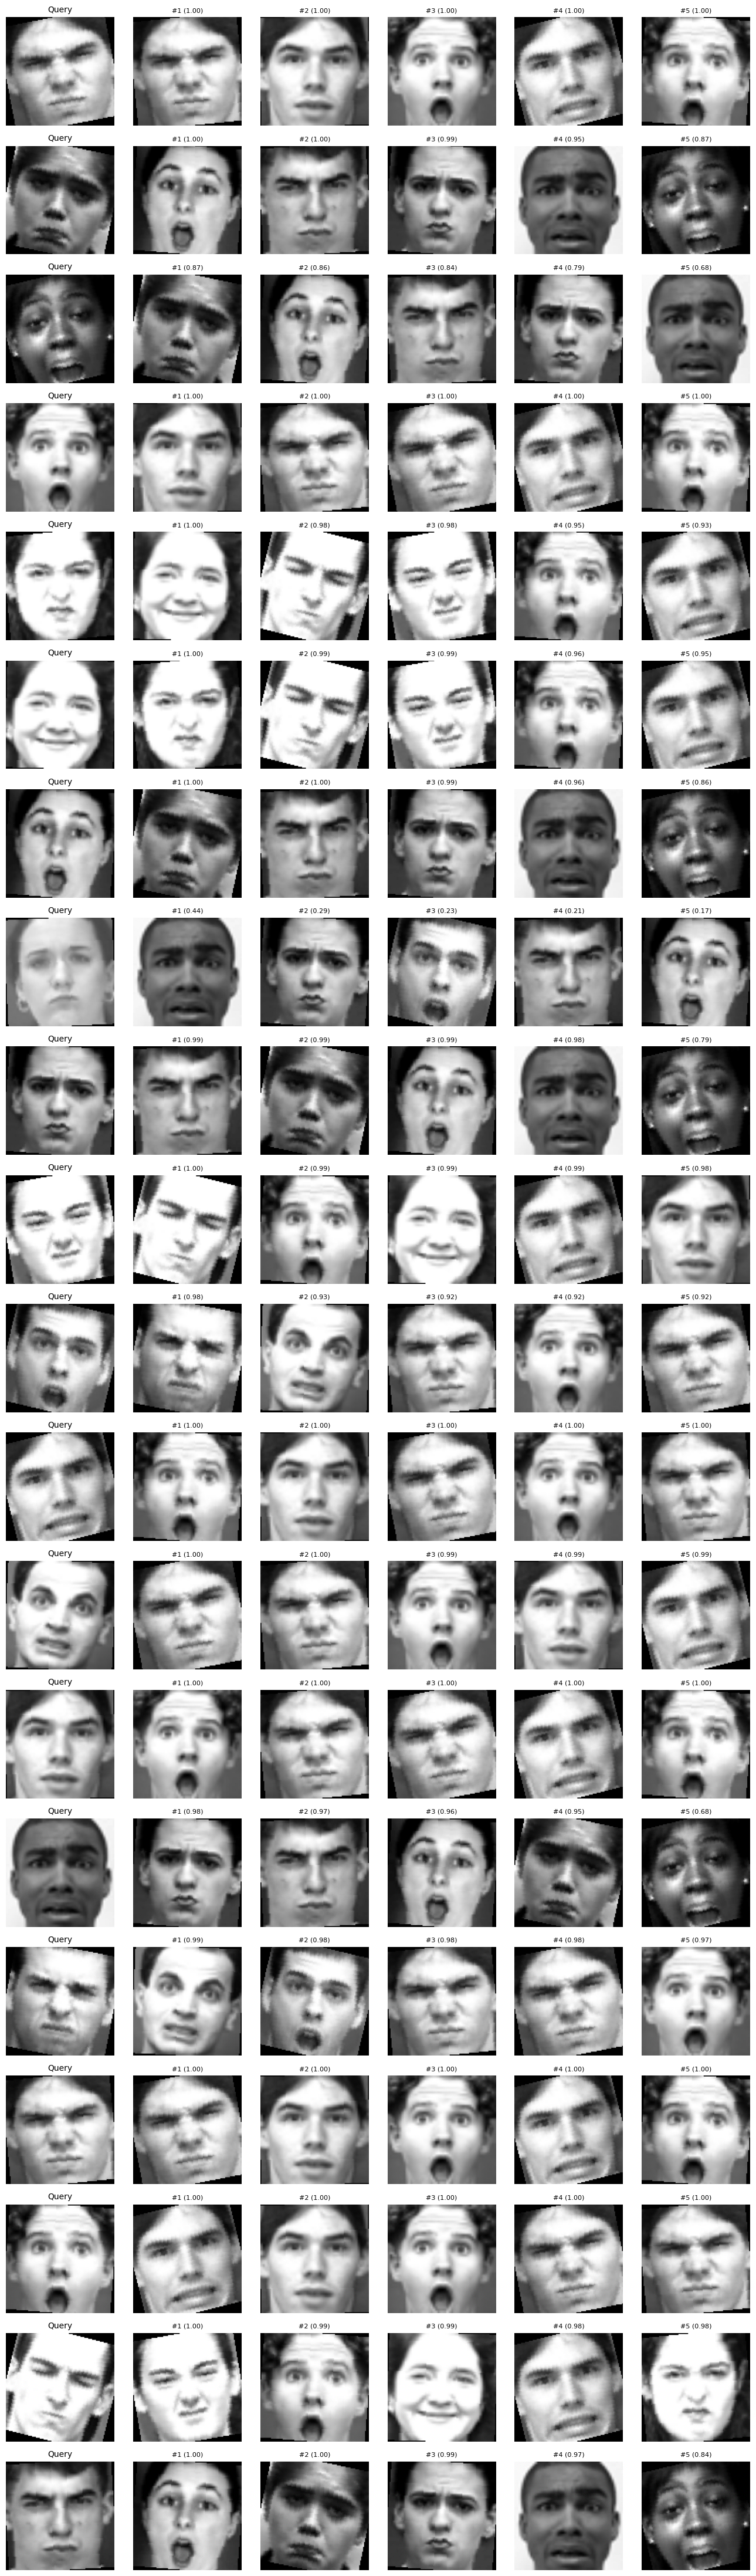

In [100]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import torch

# Ensure encoder is in eval mode
encoder_id.eval()

# Sample images and compute identity embeddings
sample_size = 20  # reduce for speed, increase as needed
sample_indices = random.sample(range(len(labeled_dataset)), sample_size)
images = []
identity_embeddings = []

for idx in sample_indices:
    img, _ = labeled_dataset[idx]
    images.append(img)
    img_tensor = img.unsqueeze(0).to(device)  # [1, 1, 224, 224]
    with torch.no_grad():
        emb = encoder_id(img_tensor).cpu()
    identity_embeddings.append(emb)

# Stack into tensor
images_tensor = torch.stack(images)  # [N, 1, 224, 224]
identity_embeddings = torch.cat(identity_embeddings, dim=0)  # [N, latent_dim]

# Cosine distance matrix
normalized_embeddings = F.normalize(identity_embeddings, dim=1)
cos_sim = torch.matmul(normalized_embeddings, normalized_embeddings.T)  # [N, N]
cos_dist = 1 - cos_sim  # cosine distance

# Plot Nearest Neighbors
def plot_identity_neighbors(images, distances, k=5):
    fig, axes = plt.subplots(len(images), k + 1, figsize=(2.2 * (k + 1), 2.2 * len(images)))

    for i in range(len(images)):
        query_img = images[i].squeeze().numpy()
        axes[i][0].imshow(query_img, cmap='gray')
        axes[i][0].set_title("Query", fontsize=10)
        axes[i][0].axis('off')

        nearest = torch.argsort(distances[i])[1:k + 1]  # Skip self
        for j, idx in enumerate(nearest):
            neighbor_img = images[idx].squeeze().numpy()
            sim_score = 1 - distances[i, idx].item()
            axes[i][j + 1].imshow(neighbor_img, cmap='gray')
            axes[i][j + 1].axis('off')
            axes[i][j + 1].set_title(f"#{j+1} ({sim_score:.2f})", fontsize=8)

    plt.tight_layout()
    plt.show()

plot_identity_neighbors(images_tensor, cos_dist)

In [101]:
def evaluate_accuracy(encoder, classifier, dataloader):
    encoder.eval()
    classifier.eval()
    correct = total = 0
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            emb, _ = encoder(imgs)
            output = classifier(emb)
            pred = output.argmax(dim=1)
            correct += (pred == labels).sum().item()
            total += labels.size(0)
    return 100.0 * correct / total

In [102]:
acc = evaluate_accuracy(encoder_exp, classifier, labeled_loader)
print(f"Accuracy on Expression Features: {acc:.2f}%")

Accuracy on Expression Features: 90.11%
